# 1. Introduction and Dataset Overview


**Dataset Name:** Water Quality Measurements

**Source:** Environmental Protection Agency (EPA), Ireland (https://data.epa.ie/bw/api/v1/measurements)

**Purpose:** This dataset contains water quality measurements, specifically levels of E. coli and Intestinal Enterococci, at various beaches in Ireland. The data is collected to monitor and assess the quality of bathing waters and ensure public health safety.

**Type of Problem:** Clustering.


**Key Features:**

* **beach_name:** Name of the beach.
* **county_name:** County where the beach is located.
* **e_coli_result:** E. coli bacteria level.
* **intestinal_enterococci_result:** Intestinal Enterococci bacteria level.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from scipy.stats import zscore
import requests
import json
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage

In [2]:
def load_data_from_api(base_url, page_size=50):
    """
    Loads water quality data from the EPA API, handling pagination.

    Args:
        base_url (str): The base URL of the API endpoint.
        page_size (int, optional): The number of results per page. Defaults to 50.

    Returns:
        pandas.DataFrame: The loaded data, or None on error.
    """
    all_data = []
    page = 1
    while True:
        url = f"{base_url}?page={page}&per_page={page_size}"
        try:
            response = requests.get(url)
            response.raise_for_status()  # Raise an exception for bad status codes
            data = response.json()

            if 'list' not in data:
                print("Error: 'list' key not found in API response.")
                return None

            if not data['list']:  # Check if the 'list' is empty, indicating no more data
                break

            all_data.extend(data['list'])
            page += 1
            print(f"Fetched page {page-1}, total data points: {len(all_data)}")
        except requests.exceptions.RequestException as e:
            print(f"Error fetching data from API: {e}")
            return None
        except json.JSONDecodeError:
            print("Error decoding JSON.  The API may not be returning valid JSON.")
            return None
        except Exception as e:
            print(f"An unexpected error occurred: {e}")
            return None

    if not all_data:
        print("No data fetched from the API.")
        return None

    df = pd.DataFrame(all_data)
    return df


## 1.1 Loading the dataset

In [3]:
base_url = "https://data.epa.ie/bw/api/v1/measurements"
df = load_data_from_api(base_url)

if df is None:
    print("Failed to load data.  Please check the data URL and ensure the data is available.")
    exit()

Fetched page 1, total data points: 50
Fetched page 2, total data points: 100
Fetched page 3, total data points: 150
Fetched page 4, total data points: 200
Fetched page 5, total data points: 250
Fetched page 6, total data points: 300
Fetched page 7, total data points: 350
Fetched page 8, total data points: 400
Fetched page 9, total data points: 450
Fetched page 10, total data points: 500
Fetched page 11, total data points: 550
Fetched page 12, total data points: 600
Fetched page 13, total data points: 650
Fetched page 14, total data points: 700
Fetched page 15, total data points: 750
Fetched page 16, total data points: 800
Fetched page 17, total data points: 850
Fetched page 18, total data points: 900
Fetched page 19, total data points: 950
Fetched page 20, total data points: 1000
Fetched page 21, total data points: 1050
Fetched page 22, total data points: 1100
Fetched page 23, total data points: 1150
Fetched page 24, total data points: 1200
Fetched page 25, total data points: 1250
Fetc

# 2. Data Preprocessing and Cleaning

In [4]:
df.head()

,monitoring_result_id,beach_id,beach_name,county_name,local_authority_name,sample_code,result_date,e_coli_result,intestinal_enterococci_result,sample_water_quality_status
0,3168,IESEBWC050_0000_0100,Ardmore Beach,Waterford,Waterford City & County Council,1450ard2205,2014-05-22,1,1,Excellent
1,3169,IESEBWC140_0000_0100,Clonea Beach,Waterford,Waterford City & County Council,1450clonea2205,2014-05-22,1,1,Excellent
2,3170,IESEBWC100_0000_0100,"Counsellors' Strand, Dunmore East",Waterford,Waterford City & County Council,1450counc2205,2014-05-22,<1,1,Excellent
3,3171,IESEBWC100_0000_0200,"Dunmore Strand, Dunmore East",Waterford,Waterford City & County Council,1450dunstrand2205,2014-05-22,124,12,Excellent
4,3172,IESEBWC110_0000_0100,Tramore Beach,Waterford,Waterford City & County Council,1450tram2205,2014-05-22,1,1,Excellent


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21735 entries, 0 to 21734
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   monitoring_result_id           21735 non-null  int64 
 1   beach_id                       21735 non-null  object
 2   beach_name                     21735 non-null  object
 3   county_name                    21735 non-null  object
 4   local_authority_name           21735 non-null  object
 5   sample_code                    21735 non-null  object
 6   result_date                    21735 non-null  object
 7   e_coli_result                  21735 non-null  object
 8   intestinal_enterococci_result  21735 non-null  object
 9   sample_water_quality_status    21735 non-null  object
dtypes: int64(1), object(9)
memory usage: 1.7+ MB


In [6]:
print(f"\nNumber of duplicate rows: {df.duplicated().sum()}")


Number of duplicate rows: 0


In [7]:
print("\nNumber of unique values per column:")
for col in df.columns:
    print(f"{col}: {df[col].nunique()}")


Number of unique values per column:
monitoring_result_id: 21735
beach_id: 227
beach_name: 225
county_name: 17
local_authority_name: 20
sample_code: 21731
result_date: 722
e_coli_result: 582
intestinal_enterococci_result: 310
sample_water_quality_status: 4


## 2.1 Dropping unwanted columns

In [8]:
unwanted_columns = ['monitoring_result_id', 'beach_id', 'sample_code', 'result_date', 'sample_water_quality_status'] 
df.drop(columns=unwanted_columns, axis=1, inplace=True,errors='ignore')
print("\nAfter Dropping Unwanted Columns:")
df.head()


After Dropping Unwanted Columns:


,beach_name,county_name,local_authority_name,e_coli_result,intestinal_enterococci_result
0,Ardmore Beach,Waterford,Waterford City & County Council,1,1
1,Clonea Beach,Waterford,Waterford City & County Council,1,1
2,"Counsellors' Strand, Dunmore East",Waterford,Waterford City & County Council,<1,1
3,"Dunmore Strand, Dunmore East",Waterford,Waterford City & County Council,124,12
4,Tramore Beach,Waterford,Waterford City & County Council,1,1


## 2.2 Handling Missing Data

In [9]:
print("\nMissing Data Before Handling:")
df.isnull().sum()


Missing Data Before Handling:


beach_name                       0
county_name                      0
local_authority_name             0
e_coli_result                    0
intestinal_enterococci_result    0
dtype: int64

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21735 entries, 0 to 21734
Data columns (total 5 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   beach_name                     21735 non-null  object
 1   county_name                    21735 non-null  object
 2   local_authority_name           21735 non-null  object
 3   e_coli_result                  21735 non-null  object
 4   intestinal_enterococci_result  21735 non-null  object
dtypes: object(5)
memory usage: 849.2+ KB


## 2.3 Transformation

In [11]:
def convert_to_numeric(value):
    """
    Converts a value to numeric, handling non-numeric characters.

    Args:
        value: The value to convert.

    Returns:
        float: The numeric value, or np.nan if conversion fails.
    """
    if isinstance(value, (int, float)):
        return value
    if isinstance(value, str):
        value = value.strip()
        if value.startswith('<'):
            return float(value[1:]) / 2
        try:
            return float(value)
        except ValueError:
            return np.nan
    return np.nan

In [12]:
df['e_coli_result'] = df['e_coli_result'].apply(convert_to_numeric)
df['intestinal_enterococci_result'] = df['intestinal_enterococci_result'].apply(convert_to_numeric)

In [13]:
df.dropna(subset=['e_coli_result', 'intestinal_enterococci_result'], inplace=True)

In [14]:
df.isna().sum()

beach_name                       0
county_name                      0
local_authority_name             0
e_coli_result                    0
intestinal_enterococci_result    0
dtype: int64

## 2.4 Handling Outliers

In [15]:
numerical_cols = ['e_coli_result', 'intestinal_enterococci_result']

In [16]:
print(f"Shape before outlier removal: {df.shape}")

Shape before outlier removal: (21686, 5)


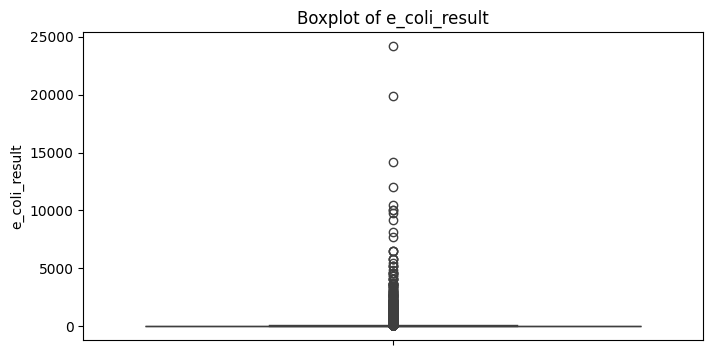

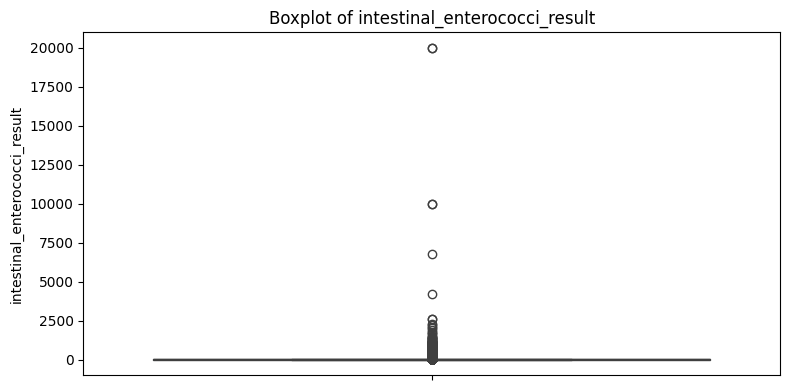

In [17]:
for i, col in enumerate(numerical_cols):
    plt.figure(figsize=(8, 4))
    sns.boxplot(y=df[col])
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

In [18]:
for col in numerical_cols:
    z_scores = np.abs(zscore(df[col]))
    df = df[z_scores <= 2]

In [19]:
print(f"Shape after outlier removal: {df.shape}")

Shape after outlier removal: (21357, 5)


# 3. Exploratory Data Analysis (EDA)

## 3.1 Descriptive Statistics

In [20]:
numerical_desc = df.describe()
numerical_desc

,e_coli_result,intestinal_enterococci_result
count,21357.000000,21357.000000
mean,42.129981,13.058061
std,92.530500,31.843263
min,0.000000,0.000000
25%,5.000000,1.000000
50%,10.000000,4.000000
75%,31.000000,10.000000
max,850.000000,420.000000


In [21]:
categorical_desc = df.describe(exclude=np.number)
categorical_desc

,beach_name,county_name,local_authority_name
count,21357,21357,21357
unique,225,17,20
top,Seapoint,Wexford,Wexford County Council
freq,400,2715,2715


## 3.3 Visualizations

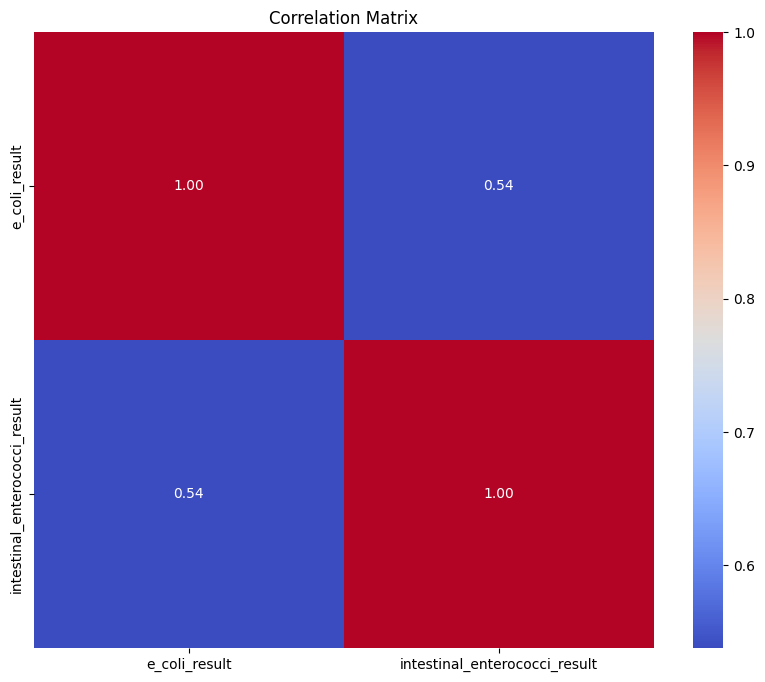

In [22]:
# Calculate correlation matrix
cor_matrix = df[numerical_cols].corr()

# Visualize correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cor_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

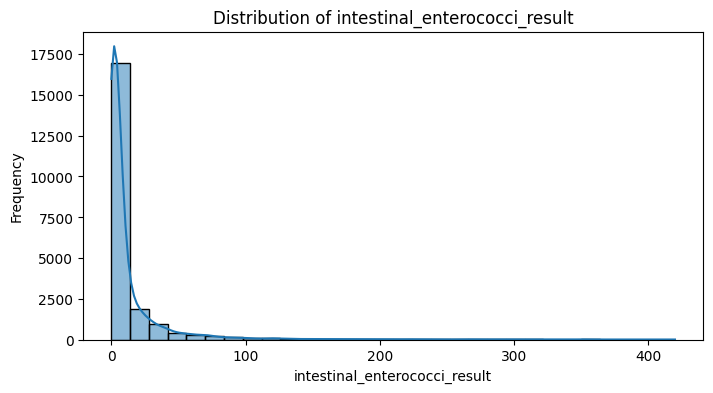

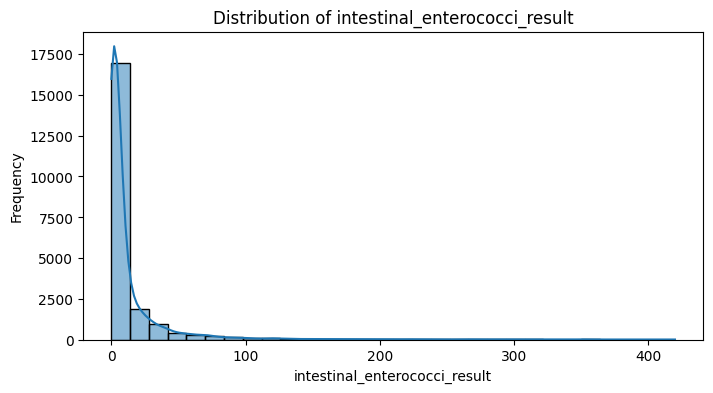

In [25]:
for x in numerical_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()


<Figure size 1000x800 with 0 Axes>

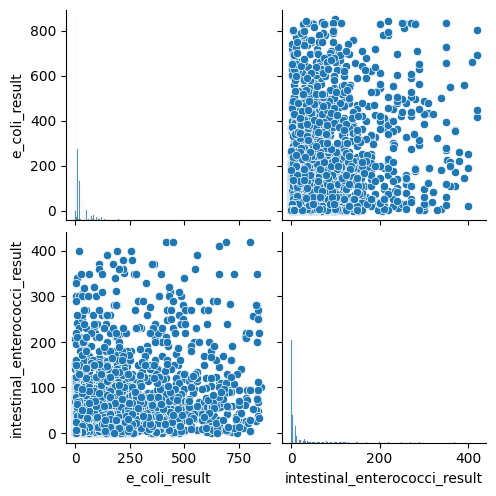

In [24]:
plt.figure(figsize=(10, 8))
sns.pairplot(df[['e_coli_result', 'intestinal_enterococci_result']])
# plt.title('Pairplot of E. coli and Intestinal Enterococci')
plt.show()

# 4. Feature Engineering 

In [26]:
scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

In [27]:
categorical_cols = ['county_name', 'beach_name','local_authority_name']
encoder = OneHotEncoder(handle_unknown='ignore')
encoded_cols = encoder.fit_transform(df[categorical_cols])
encoded_df = pd.DataFrame(encoded_cols.toarray(), columns=encoder.get_feature_names_out(categorical_cols))

# Combine the encoded columns with the numerical columns
df_encoded = pd.concat([df.drop(categorical_cols, axis=1), encoded_df], axis=1)

In [28]:
df_encoded.isna().sum()

e_coli_result                                           366
intestinal_enterococci_result                           366
county_name_Carlow                                      366
county_name_Clare                                       366
county_name_Cork                                        366
                                                       ... 
local_authority_name_Tipperary County Council           366
local_authority_name_Waterford City & County Council    366
local_authority_name_Westmeath County Council           366
local_authority_name_Wexford County Council             366
local_authority_name_Wicklow County Council             366
Length: 264, dtype: int64

In [29]:
df_encoded.dropna(inplace=True)

In [30]:
df_encoded.isna().sum()

e_coli_result                                           0
intestinal_enterococci_result                           0
county_name_Carlow                                      0
county_name_Clare                                       0
county_name_Cork                                        0
                                                       ..
local_authority_name_Tipperary County Council           0
local_authority_name_Waterford City & County Council    0
local_authority_name_Westmeath County Council           0
local_authority_name_Wexford County Council             0
local_authority_name_Wicklow County Council             0
Length: 264, dtype: int64

# 5. Model Selection and Training

## K-Means Clustering

In [31]:
pivot_scaled = df_encoded


K-Means Clustering:


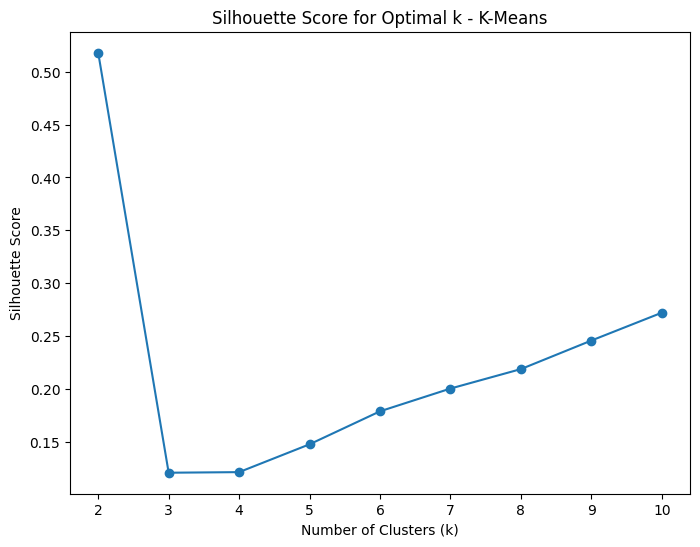

In [32]:
print("\nK-Means Clustering:")
silhouette_scores_kmeans = []
k_range = range(2, 11)  # Test for k between 2 and 10

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pivot_scaled)
    silhouette_scores_kmeans.append(silhouette_score(pivot_scaled, kmeans.labels_))

# Plot Silhouette Scores
plt.figure(figsize=(8, 6))
plt.plot(k_range, silhouette_scores_kmeans, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal k - K-Means')
plt.xticks(k_range)
plt.show()


In [33]:
# Select the best k based on the Silhouette Score
best_k_kmeans = k_range[np.argmax(silhouette_scores_kmeans)]
print(f"Optimal number of clusters (k) for K-Means: {best_k_kmeans}")

# Train K-Means with the optimal k
kmeans = KMeans(n_clusters=best_k_kmeans, random_state=42)
y_kmeans = kmeans.fit_predict(pivot_scaled)
kmeans_labels = kmeans.labels_

Optimal number of clusters (k) for K-Means: 2


In [34]:
y_kmeans

array([0, 0, 0, ..., 0, 0, 0], shape=(20991,), dtype=int32)

In [35]:
kmeans_labels

array([0, 0, 0, ..., 0, 0, 0], shape=(20991,), dtype=int32)

In [37]:
df_encoded['kmeans_cluster'] = y_kmeans

In [38]:
df_encoded.head()

,e_coli_result,intestinal_enterococci_result,county_name_Carlow,county_name_Clare,county_name_Cork,county_name_Donegal,county_name_Dublin,county_name_Galway,county_name_Kerry,county_name_Leitrim,...,local_authority_name_Louth County Council,local_authority_name_Mayo County Council,local_authority_name_Meath County Council,local_authority_name_Sligo County Council,local_authority_name_Tipperary County Council,local_authority_name_Waterford City & County Council,local_authority_name_Westmeath County Council,local_authority_name_Wexford County Council,local_authority_name_Wicklow County Council,kmeans_cluster
0,-0.444512,-0.378678,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0
1,-0.444512,-0.378678,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0
2,-0.449916,-0.378678,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0
3,0.884810,-0.033228,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0
4,-0.444512,-0.378678,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0


## Hierarchical Clustering


Hierarchical Clustering (Agglomerative):


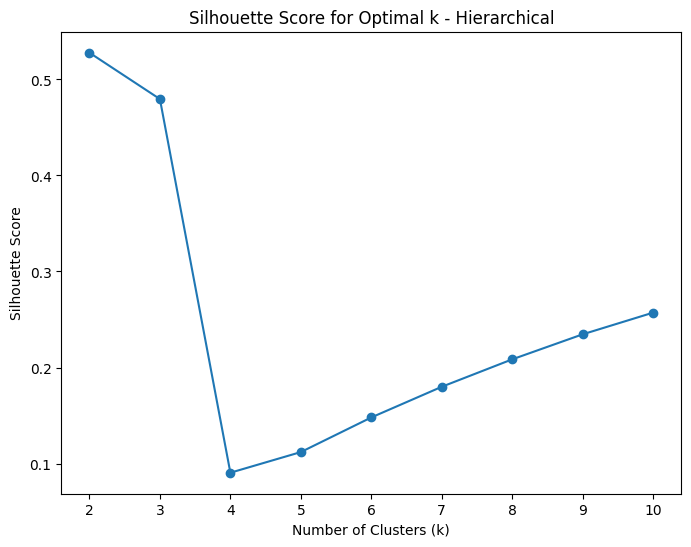

In [39]:
print("\nHierarchical Clustering (Agglomerative):")
silhouette_scores_hierarchical = []

for k in k_range:
    hierarchical = AgglomerativeClustering(n_clusters=k)
    hierarchical.fit(pivot_scaled)
    silhouette_scores_hierarchical.append(silhouette_score(pivot_scaled, hierarchical.labels_))

# Plot Silhouette Scores for Hierarchical
plt.figure(figsize=(8, 6))
plt.plot(k_range, silhouette_scores_hierarchical, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal k - Hierarchical')
plt.xticks(k_range)
plt.show()


In [40]:
# Select best k for hierarchical
best_k_hierarchical = k_range[np.argmax(silhouette_scores_hierarchical)]
print(f"Optimal number of clusters (k) for Hierarchical Clustering: {best_k_hierarchical}")

# Train Hierarchical with optimal k
hierarchical = AgglomerativeClustering(n_clusters=best_k_hierarchical)
hierarchical.fit(pivot_scaled)
hierarchical_labels = hierarchical.labels_

Optimal number of clusters (k) for Hierarchical Clustering: 2


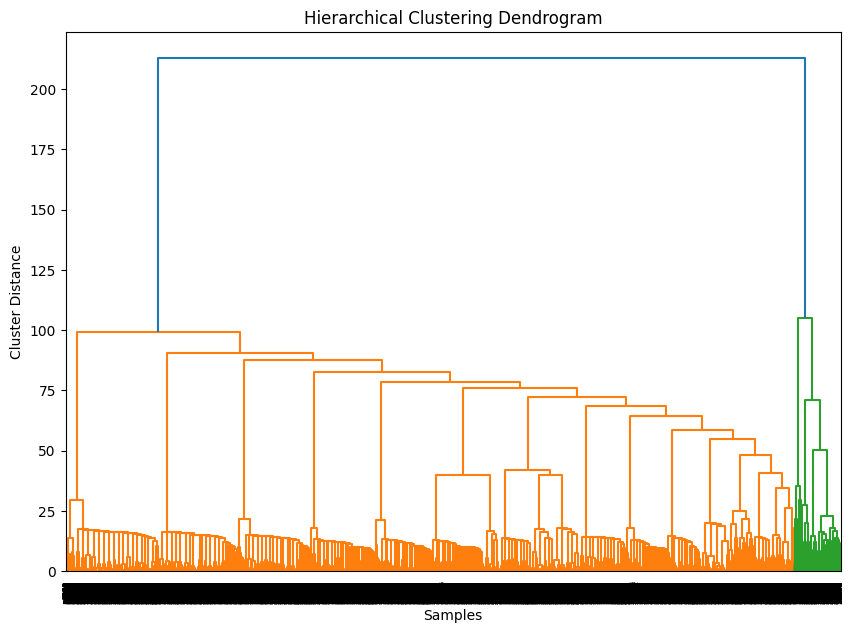

In [41]:
linked = linkage(pivot_scaled, method='ward')

plt.figure(figsize=(10, 7))
dendrogram(linked, orientation='top')
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Samples')
plt.ylabel('Cluster Distance')
plt.show()

# 5. Model Performance Evaluation

In [42]:
print("\nModel Performance Evaluation:")
# Evaluate K-Means Clustering
print("\nK-Means Clustering Evaluation:")
print(f"Silhouette Score: {silhouette_score(pivot_scaled, kmeans_labels):.3f}")
print(f"Calinski-Harabasz Index: {calinski_harabasz_score(pivot_scaled, kmeans_labels):.3f}")
print(f"Davies-Bouldin Index: {davies_bouldin_score(pivot_scaled, kmeans_labels):.3f}")

# Evaluate Hierarchical Clustering
print("\nHierarchical Clustering Evaluation:")
print(f"Silhouette Score: {silhouette_score(pivot_scaled, hierarchical_labels):.3f}")
print(f"Calinski-Harabasz Index: {calinski_harabasz_score(pivot_scaled, hierarchical_labels):.3f}")
print(f"Davies-Bouldin Index: {davies_bouldin_score(pivot_scaled, hierarchical_labels):.3f}")


Model Performance Evaluation:

K-Means Clustering Evaluation:
Silhouette Score: 0.527
Calinski-Harabasz Index: 6060.952
Davies-Bouldin Index: 1.165

Hierarchical Clustering Evaluation:
Silhouette Score: 0.528
Calinski-Harabasz Index: 5966.370
Davies-Bouldin Index: 1.171


## 2D PCA for visualization

In [ ]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(pivot_scaled)

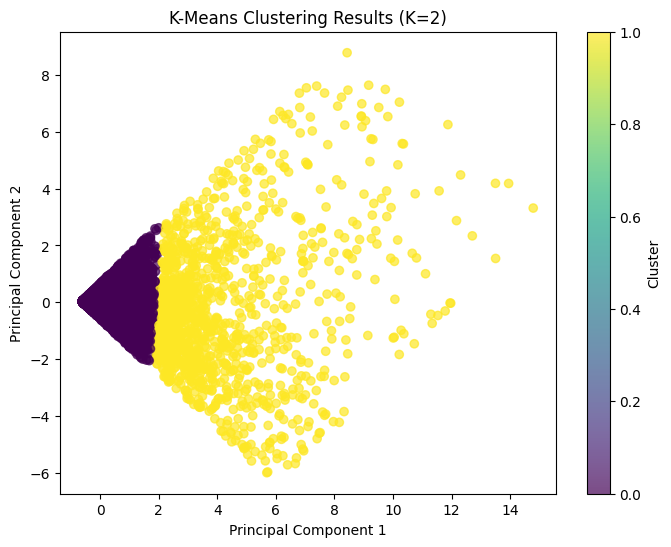

In [44]:
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.7)
plt.title(f'K-Means Clustering Results (K={best_k_kmeans})')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.show()

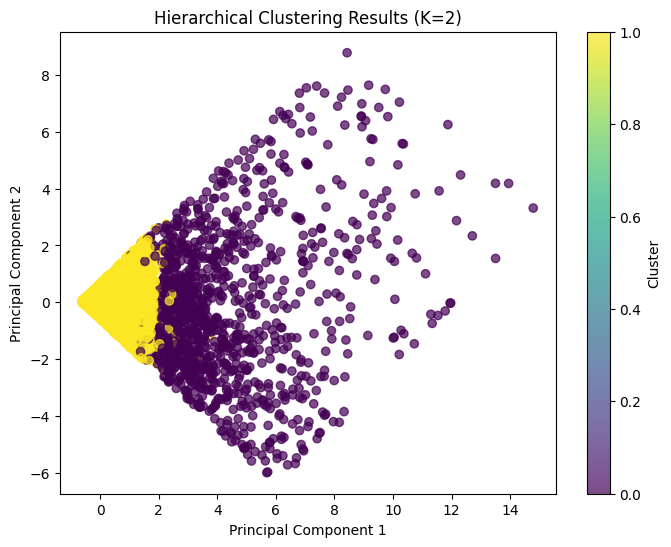

In [45]:
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=hierarchical_labels, cmap='viridis', alpha=0.7)
plt.title(f'Hierarchical Clustering Results (K={best_k_hierarchical})')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.show()

# 6. Compare Model Results

In [46]:
print("\nModel Comparison:")
print("K-Means Clustering:")
print(f"  Optimal k: {best_k_kmeans}")
print("Hierarchical Clustering:")
print(f"  Optimal k: {best_k_hierarchical}")

# Create a summary table for comparison
comparison_table = pd.DataFrame({
    'Metric': ['Silhouette Score', 'Calinski-Harabasz Index', 'Davies-Bouldin Index'],
    'K-Means': [
        silhouette_score(pivot_scaled, kmeans_labels),
        calinski_harabasz_score(pivot_scaled, kmeans_labels),
        davies_bouldin_score(pivot_scaled, kmeans_labels)
    ],
    'Hierarchical': [
        silhouette_score(pivot_scaled, hierarchical_labels),
        calinski_harabasz_score(pivot_scaled, hierarchical_labels),
        davies_bouldin_score(pivot_scaled, hierarchical_labels)
    ]
}) 
print(comparison_table)


Model Comparison:
K-Means Clustering:
  Optimal k: 2
Hierarchical Clustering:
  Optimal k: 2
                    Metric      K-Means  Hierarchical
0         Silhouette Score     0.527147      0.527788
1  Calinski-Harabasz Index  6060.952258   5966.370168
2     Davies-Bouldin Index     1.164902      1.171177
